In [95]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import RebapCalc
from sklearn.preprocessing import normalize

In [96]:
cnx = sqlite3.connect('Prognosedaten.db')
strSQL = 'SELECT *, RE_PV_Ante-RE_PV_Post AS PV_error, RE_WI_Ante-RE_WI_Post AS WI_error from GridLoad,Rebap, SRL, MRL,Intraday, NRV, RE, SpotMarket WHERE SRL.SRL_DateTime = RE.RE_DateTime AND SRL.SRL_DateTime = GridLoad.GridLoad_DateTime AND SRL.SRL_DateTime = Rebap.Rebap_DateTime AND SRL.SRL_DateTime = MRL.MRL_DateTime AND SRL.SRL_DateTime = Intraday.Intraday_DateTime AND SRL.SRL_DateTime = NRV.NRV_DateTime AND SRL.SRL_DateTime = SpotMarket.Spot_DateTime AND SRL.SRL_AbgerMenge_Pos <> "-" AND SRL.SRL_AbgerMenge_Neg <> "-" AND SRL.SRL_Leistungspreis_Neg <> "-" AND SRL.SRL_Leistungspreis_POS <> "-" AND MRL_DateTime NOT LIKE "%2018%"'

df = pd.read_sql_query(strSQL,cnx)

df = df.drop("SRL_DateTime",axis=1)
df = df.drop("SRL_Key",axis=1)
df = df.drop("MRL_DateTime",axis=1)
df = df.drop("MRL_Key",axis=1)
df = df.drop("Intraday_DateTime",axis=1)
df = df.drop("Intraday_Key",axis=1)
df = df.drop("NRV_DateTime",axis=1)
df = df.drop("NRV_Key",axis=1)
df = df.drop("Spot_DateTime",axis=1)
df = df.drop("Spot_Key",axis=1)
df = df.drop("RE_DateTime",axis=1)
df = df.drop("RE_Key",axis=1)
df = df.drop("Rebap_DateTime",axis=1)
df = df.drop("Rebap_Key",axis=1)
df = df.drop("GridLoad_DateTime",axis=1)
df = df.drop("GridLoad_Key",axis=1)

#df = df.drop("GridLoad_val",axis=1)
#df = df.drop("SRL_VorgehMenge_Pos",axis=1)
#df = df.drop("SRL_VorgehMenge_Neg",axis=1)
df = df.drop("SRL_Leistungspreis_Pos",axis=1) 
df = df.drop("SRL_Leistungspreis_Neg",axis=1)
#df = df.drop("MRL_VorgehMenge_Pos",axis=1)
#df = df.drop("MRL_VorgehMenge_Neg",axis=1)
df = df.drop("MRL_Leistungspreis_Pos",axis=1)
df = df.drop("MRL_Leistungspreis_Neg",axis=1)
#df = df.drop("Intraday_Preis",axis=1)
#df = df.drop("Intraday_Volumen",axis=1)
df = df.drop("RE_PV_Ante",axis=1)
df = df.drop("RE_WI_Ante",axis=1)
df = df.drop("RE_PV_Post",axis=1) 
df = df.drop("RE_WI_Post",axis=1)
df = df.drop("Spot_Price",axis=1)
df = df.drop("Spot_Vol",axis=1)


df = df.drop(['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','NRV_Saldo'],axis=1)
#print(df.shape)
#print(df.columns)



Index(['GridLoad_val', 'SRL_VorgehMenge_Pos', 'SRL_VorgehMenge_Neg',
       'MRL_VorgehMenge_Pos', 'MRL_VorgehMenge_Neg', 'Intraday_Preis',
       'Intraday_Volumen', 'PV_error', 'WI_error'],
      dtype='object')
Data poccessed starting on the ML stuff
[[6.96821343e-05]
 [6.96821343e-05]
 [6.96821343e-05]
 ...
 [6.35793447e-05]
 [6.35793447e-05]
 [6.35793447e-05]]


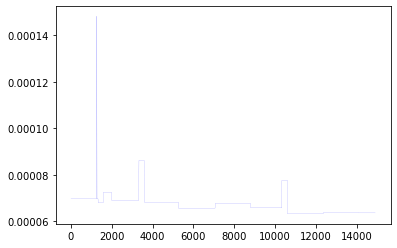

In [97]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

Y_MRL_AbgerMenge_Pos = test['MRL_AbgerMenge_Pos'].copy().to_numpy()
train = train.drop('MRL_AbgerMenge_Pos',axis=1)
test = test.drop('MRL_AbgerMenge_Pos',axis=1)
Y_MRL_Arbeitspreis_Pos = test['MRL_Arbeitspreis_Pos'].copy().to_numpy()
train = train.drop('MRL_Arbeitspreis_Pos',axis=1)
test = test.drop('MRL_Arbeitspreis_Pos',axis=1)
Y_MRL_AbgerMenge_Neg = test['MRL_AbgerMenge_Neg'].copy().to_numpy()
train = train.drop('MRL_AbgerMenge_Neg',axis=1)
test = test.drop('MRL_AbgerMenge_Neg',axis=1)
Y_MRL_Arbeitspreis_Neg = test['MRL_Arbeitspreis_Neg'].copy().to_numpy()
train = train.drop('MRL_Arbeitspreis_Neg',axis=1)
test = test.drop('MRL_Arbeitspreis_Neg',axis=1)

rebap_test = (test['Rebap_Preis']).copy().to_numpy()
rebaptemp = test['Rebap_Preis'].copy().to_numpy()

pdY_train = train['Rebap_Preis'].copy()
pdX_train = train.drop(['Rebap_Preis'], axis=1)

pdY_test = test[['Rebap_Preis']].copy()
pdX_test = test.drop(['Rebap_Preis'], axis=1)

Xtrain = pdX_train.to_numpy()
Ytrain = pdY_train.to_numpy()

Xtest  = pdX_test.to_numpy()
Ytest  = pdY_test.to_numpy()
print(pdX_test.columns)
print("Data poccessed starting on the ML stuff")
#print(Xtest[:, [2]])
#plt.plot(Xtest[:, [2]],color='blue',linewidth=0.1)
#plt.show()

In [98]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [99]:
def get_model():

	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(20, activation='softmax', input_shape=[Xtrain.shape[1]]))
	model.add(keras.layers.Dense(68, activation='softmax'))
	model.add(keras.layers.Dense(50, activation='softmax'))
	model.add(keras.layers.Dense(40, activation='softmax'))
	model.add(keras.layers.Dense(30, activation='softmax'))
	model.add(keras.layers.Dense(20, activation='softmax'))
	model.add(keras.layers.Dense(10, activation='softmax'))
	model.add(tf.keras.layers.Dense(1))
	
	sgd = tf.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
	rmspop = tf.keras.optimizers.RMSprop(0.001)#chills at 2.3
	model.compile(optimizer=rmspop,loss='mean_squared_error')
	return model

In [92]:
model = get_model()
_ = model.fit(Xtrain,Ytrain,
	#batch_size=64,
	epochs=10,
	#steps_per_epoch=5,
	#verbose=0,
	validation_data = (Xtest,Ytest))#,
	#callbacks=[callback])
#print(pdX_train)

Epoch 1/10
1864/1864 [==============================] - 6s 3ms/step - loss: 11315.7188 - val_loss: 5153.5981
Epoch 2/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10990.0186 - val_loss: 5034.5439
Epoch 3/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10953.3691 - val_loss: 5026.7432
Epoch 4/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10944.5801 - val_loss: 5026.8066
Epoch 5/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10944.8613 - val_loss: 5026.8794
Epoch 6/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10944.9668 - val_loss: 5026.6646
Epoch 7/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10944.7500 - val_loss: 5026.6553
Epoch 8/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10945.0986 - val_loss: 5026.7129
Epoch 9/10
1864/1864 [==============================] - 6s 3ms/step - loss: 10944.8105 - val_loss: 5026.9043
Epoch 10/10
1864/18

RMS: 
70.90372860835353
%diff
78.55801475519786


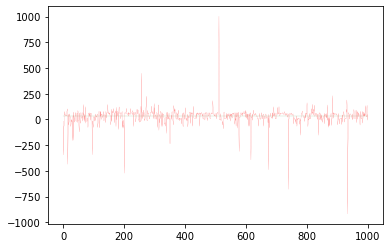

In [93]:
predictions = model.predict(Xtest)

#truth = Y_MRL_Arbeitspreis_Pos >= predictions
#for i in range(truth.shape[0]):
#    if (truth[0][i]):
#        predictions[i] = Y_MRL_Arbeitspreis_Pos[i]

differences = predictions*Ytest
truth = (differences >  0)

rms = sqrt(mean_squared_error(predictions, Ytest))
print("RMS: ")
print(rms)
print("%diff")
print(100*(np.sum(truth)/predictions.shape[0]))
truth = truth*1000
plt.plot(predictions[:1000],color='green',linewidth=0.1)
plt.plot(Ytest[:1000],color='red',linewidth=0.1)
plt.plot(Xtest[:1000, [0]],color='yellow',linewidth=0.1)
#plt.plot(Y_MRL_AbgerMenge_Pos[:1000],color='blue',linewidth=0.1)
#plt.plot(Y_MRL_Arbeitspreis_Neg[:1000],color='yellow',linewidth=0.1)
#plt.plot(Y_MRL_AbgerMenge_Neg[:1000],color='blue',linewidth=0.1)
plt.show()





In [94]:
et = np.array([[1, 2, 3] ,[4, 5, 6],[7,8,9]])
normed_matrix = normalize(et, axis=0, norm='l1')
print(et)
print(normed_matrix)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.08333333 0.13333333 0.16666667]
 [0.33333333 0.33333333 0.33333333]
 [0.58333333 0.53333333 0.5       ]]
